In [1]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

# Chapter 1: Importing Recording Data and Metadata

## Part 2: Importing Preinstalled Libraries

In [2]:
import os
import glob
from pathlib import Path
from collections import defaultdict
import pickle
import imp
import datetime
import time
import multiprocessing
import dask

/tmp/ipykernel_922488/366434120.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Changing the figure size
from matplotlib.pyplot import figure

# Increase size of plot in jupyter
plt.rcParams["figure.figsize"] = (10,6)

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [5]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.preprocessing as sp
from spikeinterface import WaveformExtractor, extract_waveforms

/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import spikeinterface.core

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [7]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [8]:
from spikeinterface.exporters import export_to_phy

# Part 3: Looking over Raw Ephys Recording

## Loading in the Electrophysiology Recording

- Please look at this website to see which importing method matches your data format. https://spikeinterface.readthedocs.io/en/latest/modules/extractors/plot_1_read_various_formats.html#sphx-glr-modules-extractors-plot-1-read-various-formats-py
- You can also try tab completing `se.read_` and see what other electrophysiology data formats are accepted
    - All the different options for importing electrophysiology data:

In [11]:
for method in dir(se):
    if method.startswith("read"):
        print(method)

read_alf_sorting
read_alphaomega
read_alphaomega_event
read_axona
read_bids
read_biocam
read_blackrock
read_blackrock_sorting
read_cbin_ibl
read_ced
read_cellexplorer
read_combinato
read_edf
read_hdsort
read_herdingspikes
read_ibl_streaming_recording
read_intan
read_kilosort
read_klusta
read_maxwell
read_maxwell_event
read_mclust
read_mcsh5
read_mcsraw
read_mda_recording
read_mda_sorting
read_mearec
read_neuralynx
read_neuralynx_sorting
read_neuroscope
read_neuroscope_recording
read_neuroscope_sorting
read_nix
read_nwb
read_nwb_recording
read_nwb_sorting
read_openephys
read_openephys_event
read_phy
read_plexon
read_plexon_sorting
read_shybrid_recording
read_shybrid_sorting
read_spike2
read_spikegadgets
read_spikeglx
read_spykingcircus
read_tdt
read_tridesclous
read_waveclus
read_waveclus_snippets
read_yass


- Getting a list of all the electrophysiological recording files
    - **NOTE**: If your recording file does not end with `.rec` or is in a different directory than `./data` then you must change `glob.glob("{**/*merged*.rec}")` below. Where you replace `"{**/*merged*.rec}"` with the path to your recording file without the brackets.

In [65]:
# Getting all the file paths of the recording files(that happen to all end in `.txt`)
all_recording_files = glob.glob("./data/**/*merged*.rec", recursive=True)

In [66]:
all_recording_files

['./data/20221219_124942_6_1_novel.rec/needed_files/20221219_124942_6_1_novel_merged.rec']

- If you have more than one recording file, then you must either:
    - A. Put the index of the file in `all_recording_files[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `glob.glob("{**/*merged*.rec}")` below. You would replace `{**/*merged*.rec}` with the path of the file for the metadata.

- Reading in the data into Spikeinterface
    - **NOTE**: If you are not using Spikegadgets to record your electrophysiological data, then you must change the `read_spikegadgets` below to the format/device that you are using. Look at list above to see which one matches yours.  

In [68]:
recording_file_root = os.path.basename(all_recording_files[0])

recording_file_root = os.path.splitext(recording_file_root)[0]


In [69]:
recording_file_root

'20221219_124942_6_1_novel_merged'

In [70]:
parent_output_directory = "./proc/{}".format(recording_file_root)

In [71]:
trodes_recording = se.read_spikegadgets(all_recording_files[0], stream_id="trodes")

## Metadata from the recording file

This is how you retrieve info from a :code:`RecordingExtractor`...



In [72]:
channel_ids = trodes_recording.get_channel_ids()
fs = trodes_recording.get_sampling_frequency()
num_chan = trodes_recording.get_num_channels()
num_seg = trodes_recording.get_num_segments()
duration = trodes_recording.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 24011275
Number of hours: 0.33348993055555554


In [73]:
recording = trodes_recording

## Plotting the electrophysiology activity

:code:`recording` is a :code:`RecordingExtractor` object, which extracts information about channel ids, channel locations
(if present), the sampling frequency of the recording, and the extracellular  traces. :code:`sorting_true` is a
:code:`SortingExtractor` object, which contains information about spike-sorting related information,  including unit ids,
spike trains, etc.
Let's use the :code:`widgets` module to visualize the traces and the raster plots.



- Plotting the activity for all channels for the first 5 seconds
    - Check to see if there's any activity.
    - You can adjust the time by changing `time_range=(0, 5)`. The first number is when the plotting starts in seconds, and the second number is the when the plotting ends.

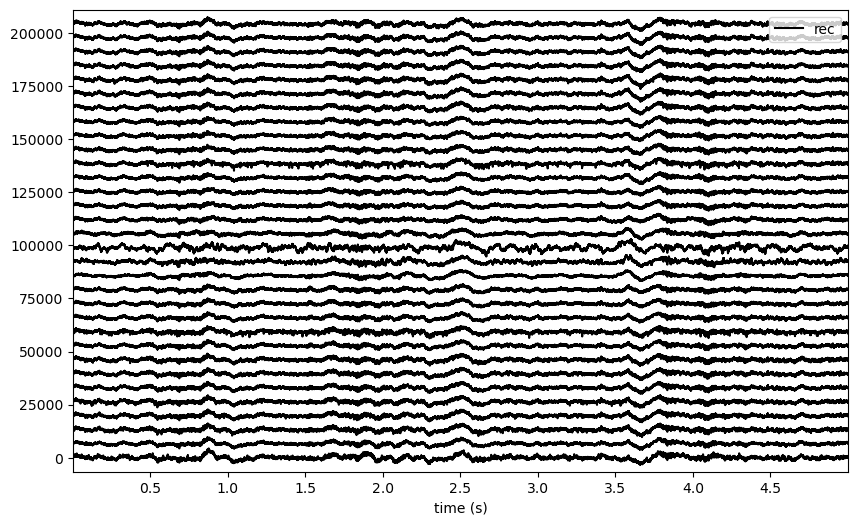

In [74]:
w_ts = sw.plot_timeseries(recording, time_range=(0, 5))

# Part 2: Setting Probes

- Adding the information about the probes used to record the electrophysiology data.
- If you are using different probes, take a look at:
    - https://probeinterface.readthedocs.io/_/downloads/en/latest/pdf/
    - https://spikeinterface.readthedocs.io/en/latest/modules/core/plot_3_handle_probe_info.html#sphx-glr-modules-core-plot-3-handle-probe-info-py

## Reading in a Probe file

In [75]:
# Getting all the file paths of the recording parameter files(that happen to all end in `.prm`)
all_probe_files = glob.glob("**/*.prb", recursive=True)

In [76]:
all_probe_files

['data/20221219_124942_6_1_novel.rec/needed_files/nancyprobe_linearprobelargespace.prb']

- If you have more than one metadata file, then you must either:
    - A. Put the index of the file in `all_probe_files[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `glob.glob("{**/*.prb})"` below. You would replace `{**/*.prb}` with the path of the file for the metadata.

In [77]:
if len(all_probe_files) < 1:
    warnings.warn("There are no parameter files in the directory that you specified. Please add a file, or correct the directory path")
else:
    probe_parameters = imp.load_source("probe_parameters", all_probe_files[0])
    with open(all_probe_files[0]) as info_file:
        lines = info_file.readlines()
        for line in lines:
            print(line)

channel_groups = {0: {'channels': [0,

                  1,

                  2,

                  3,

                  4,

                  5,

                  6,

                  7,

                  8,

                  9,

                  10,

                  11,

                  12,

                  13,

                  14,

                  15,

                  16,

                  17,

                  18,

                  19,

                  20,

                  21,

                  22,

                  23,

                  24,

                  25,

                  26,

                  27,

                  28,

                  29,

                  30,

                  31],

     'geometry':{

    0: (0, 0),

    1: (5, 20),

    2: (-7, 40),

    3: (9, 60),

    4: (-11, 80),

    5: (13, 100),

    6: (-15, 120),

    7: (17, 140),

    8: (-19, 160),

    9: (21, 180),

    10: (-23, 200),

    11: (25, 220),

    12: (-27

- Reading in the probe information into Spike interface and plotting the probe

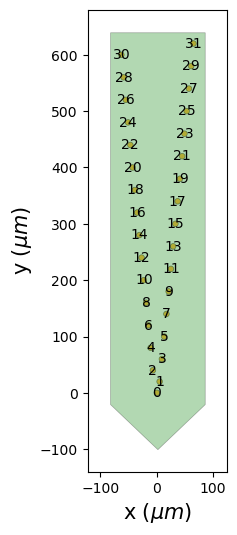

In [78]:
if len(all_probe_files) < 1:
    warnings.warn("There are no parameter files in the directory that you specified. Please add a file, or correct the directory path")
else:
    # Reading in the probe data
    probe_object = read_prb(all_probe_files[0])
    # Setting the probe to the recording object
    recording = recording.set_probes(probe_object)
    # Plotting the probe configuration
    plot_probe_group(probe_object, same_axes=True, with_channel_index=True)
    plt.show()

In [79]:

probe_object.to_dataframe()

,probe_index,x,y,contact_shapes,radius,shank_ids,contact_ids
0,0,0.0,0.0,circle,5.0,,
1,0,5.0,20.0,circle,5.0,,
2,0,-7.0,40.0,circle,5.0,,
3,0,9.0,60.0,circle,5.0,,
4,0,-11.0,80.0,circle,5.0,,
5,0,13.0,100.0,circle,5.0,,
6,0,-15.0,120.0,circle,5.0,,
7,0,17.0,140.0,circle,5.0,,
8,0,-19.0,160.0,circle,5.0,,
9,0,21.0,180.0,circle,5.0,,


In [80]:
probe_object.get_global_device_channel_indices()

array([(0,  0), (0,  1), (0,  2), (0,  3), (0,  4), (0,  5), (0,  6),
       (0,  7), (0,  8), (0,  9), (0, 10), (0, 11), (0, 12), (0, 13),
       (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20),
       (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27),
       (0, 28), (0, 29), (0, 30), (0, 31)],
      dtype=[('probe_index', '<i8'), ('device_channel_indices', '<i8')])

In [81]:
os.makedirs(parent_output_directory, exist_ok=True)

In [82]:
recording_output_directory = os.path.join(parent_output_directory, "recording_raw")

In [83]:
recording_output_directory

'./proc/20221219_124942_6_1_novel_merged/recording_raw'

In [84]:
if not os.path.exists(recording_output_directory):
    recording.save_to_folder(name="recording_raw", folder=recording_output_directory)
else:
    warnings.warn("""Directory already exists for: {}. 
    Either continue on if you are satisfied with the previous run 
    or delete the directory and run this cell again""".format(recording_output_directory))

write_binary_recording with n_jobs = 1 and chunk_size = 20000


write_binary_recording: 100%|#| 1201/1201 [00:03<00:


# Chapter 2: Preprocessing Recording

- Preproccessing the signal to improve the spike sorting performance

- **NOTE**: If you want to add preprocessing steps, you must either make additional code cells to a similar format as below or change the commented code cells by removing the `"""`
    - Here are more available preprocessing techniques: 
    - https://spikeinterface.readthedocs.io/en/latest/modules/preprocessing.html

- **NOTE**: If you want to remove preprocessing steps, you must turn unneeded `Code` cells into comments(Put `"""` at the top, and `"""` at the bottom)`Raw NBConvert` cells.

- **NOTE**: If you want to reorder the preprocessing steps, you must reorder the `Code` cells by clicking on the up or down arrow on the top menu when you have the `Code` cell clicked.

- All available preprocessing methods shown below:

In [85]:
for method in dir(spikeinterface.preprocessing):
    print(method)


AlignSnippets
BandpassFilterRecording
BlankSaturationRecording
CenterRecording
ClipRecording
CommonReferenceRecording
DeepInterpolatedRecording
FilterRecording
HighpassFilterRecording
HighpassSpatialFilterRecording
InterpolateBadChannelsRecording
NormalizeByQuantileRecording
NotchFilterRecording
PhaseShiftRecording
RectifyRecording
RemoveArtifactsRecording
ResampleRecording
ScaleRecording
WhitenRecording
ZScoreRecording
ZeroChannelPaddedRecording
__builtins__
__cached__
__doc__
__file__
__loader__
__name__
__package__
__path__
__spec__
align_snippets
bandpass_filter
basepreprocessor
blank_staturation
center
clip
common_reference
correct_lsb
deepinterpolate
deepinterpolation
detect_bad_channels
filter
get_spatial_interpolation_kernel
highpass_filter
highpass_spatial_filter
installed_preprocessers_list
interpolate_bad_channels
normalize_by_quantile
normalize_scale
notch_filter
phase_shift
preprocesser_dict
preprocessers_full_list
preprocessing_tools
preprocessinglist
rectify
remove_artif

In [86]:
preprocessing_step_dict = defaultdict(dict)

In [87]:
preprocessing_step_dict["recording_raw"] = recording_intermediate = recording

In [88]:
# Bandpass Filtering, keeping all the points that are within a certain frequency range
recording_bandpass = sp.bandpass_filter(recording_intermediate, freq_min=300, freq_max=6000)
recording_intermediate = sp.bandpass_filter(recording_intermediate, freq_min=300, freq_max=6000)
preprocessing_step_dict["recording_bandpass"] = recording_bandpass
print(recording_bandpass)

BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 1200.564s


In [89]:
spikeinterface.preprocessing.detect_bad_channels(recording_intermediate)

(array([], dtype='<U64'),
 array(['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
        'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
        'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
        'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good'],
       dtype='<U5'))

In [90]:
# Re-referencing with common median reference
recording_median_reference = sp.common_reference(recording_intermediate, reference='global', operator='median')
recording_intermediate = sp.common_reference(recording_intermediate, reference='global', operator='median')
preprocessing_step_dict["recording_median_reference"] = recording_median_reference
print(recording_median_reference)

CommonReferenceRecording: 32 channels - 1 segments - 20.0kHz - 1200.564s


In [91]:
preprocessing_step_dict

defaultdict(dict,
            {'recording_raw': SpikeGadgetsRecordingExtractor: 32 channels - 1 segments - 20.0kHz - 1200.564s
               file_path: ./data/20221219_124942_6_1_novel.rec/needed_files/20221219_124942_6_1_novel_merged.rec,
             'recording_bandpass': BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 1200.564s,
             'recording_median_reference': CommonReferenceRecording: 32 channels - 1 segments - 20.0kHz - 1200.564s})

# Part 3: Visualization and EDA

## Plotting the Time Series

- Plotting with lines are better for recordings with smaller channel numbers

In [92]:
time_difference = 1

In [93]:
start_time = 300

In [94]:
time_range = [start_time, start_time + time_difference] 

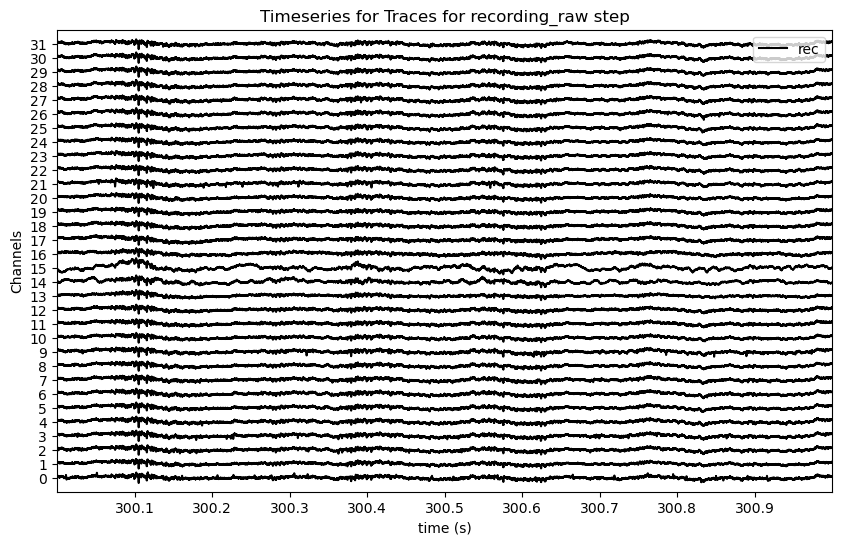

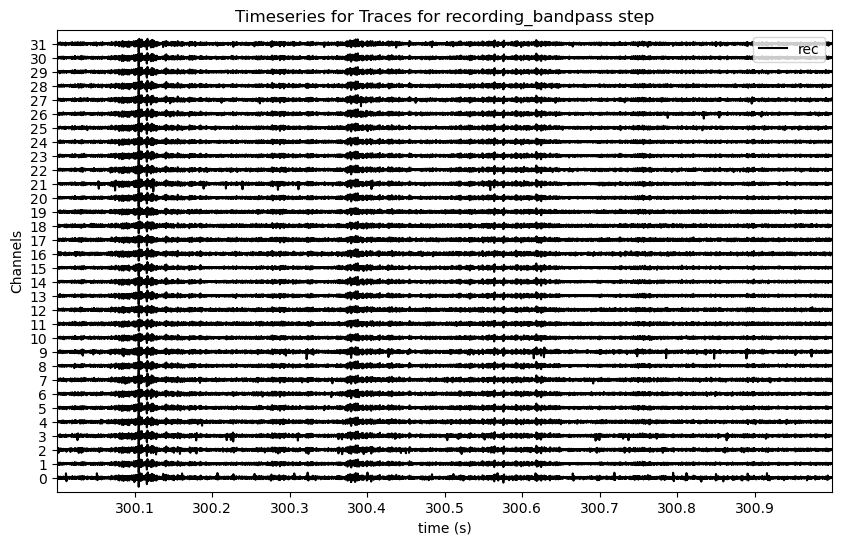

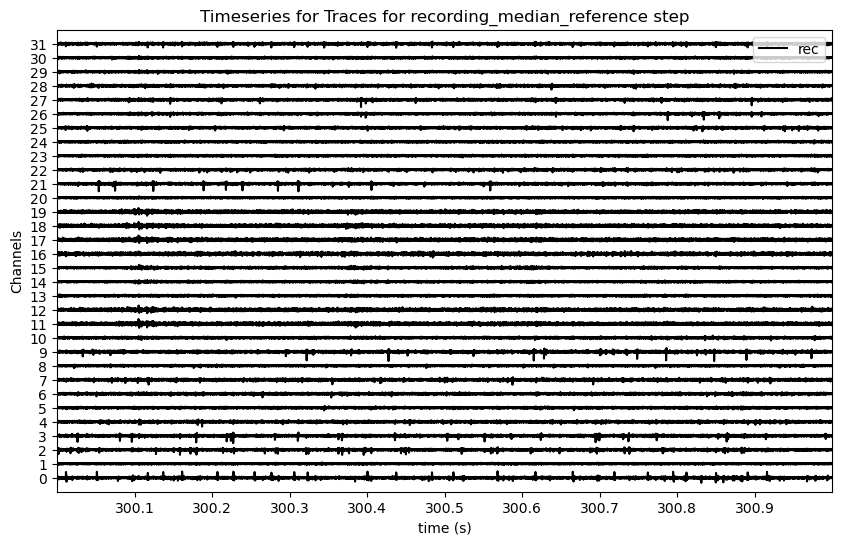

In [95]:
for key, value in preprocessing_step_dict.items():
    sw.plot_timeseries(value, time_range=(time_range[0], time_range[1]), show_channel_ids=True) #, figure=fig)
    plt.title("Timeseries for Traces for {} step".format(key))
    plt.ylabel("Channels")
    plt.show()

- Looking more closely at a few of the channels
    - The Channel IDs:

In [96]:
recording_intermediate.channel_ids

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U64')

In [97]:
channel_ids = np.random.choice(recording_intermediate.channel_ids, size=5, replace=False)

In [98]:
channel_ids = sorted(channel_ids, key=lambda x: float(x))

In [99]:
channel_ids

['2', '5', '6', '25', '30']

- If you want to use a specific set of channels, change the channels in the cell below and turn it into a `Code` cell

In [100]:
# Best channels with current setup
channel_ids = ["31", "17", "16", "15", "13"]

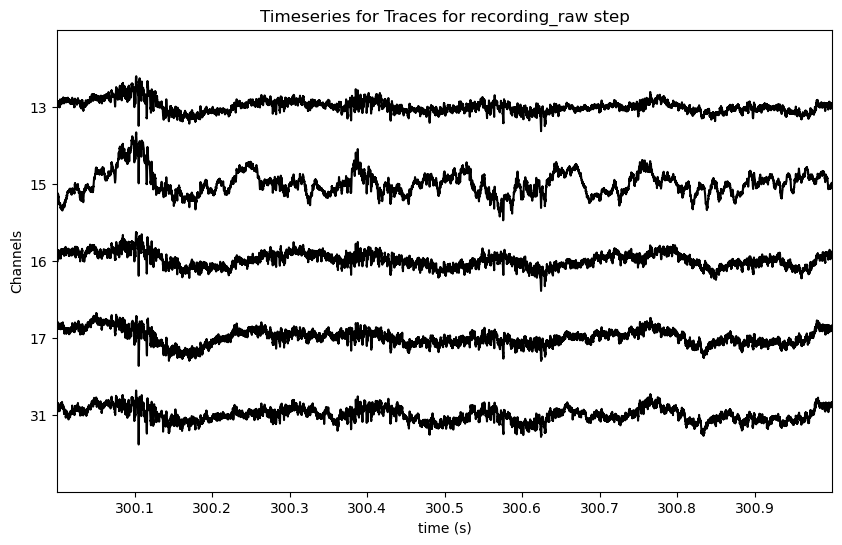

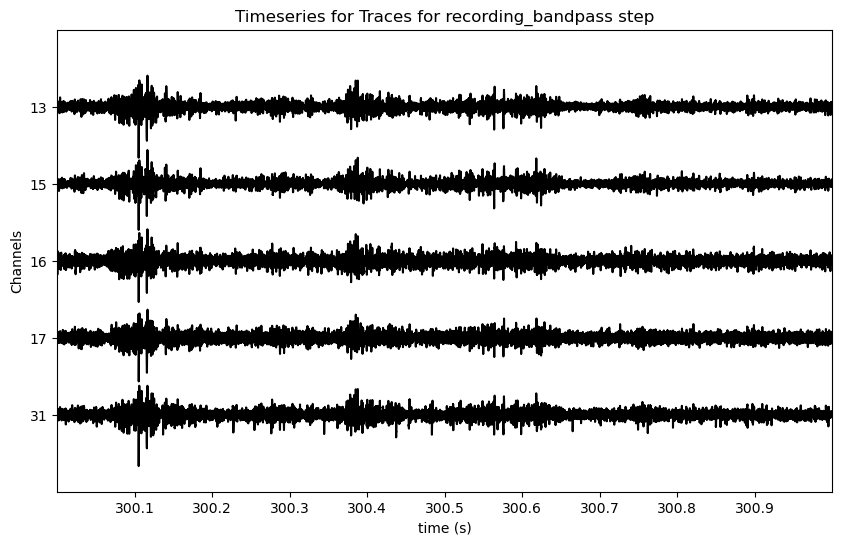

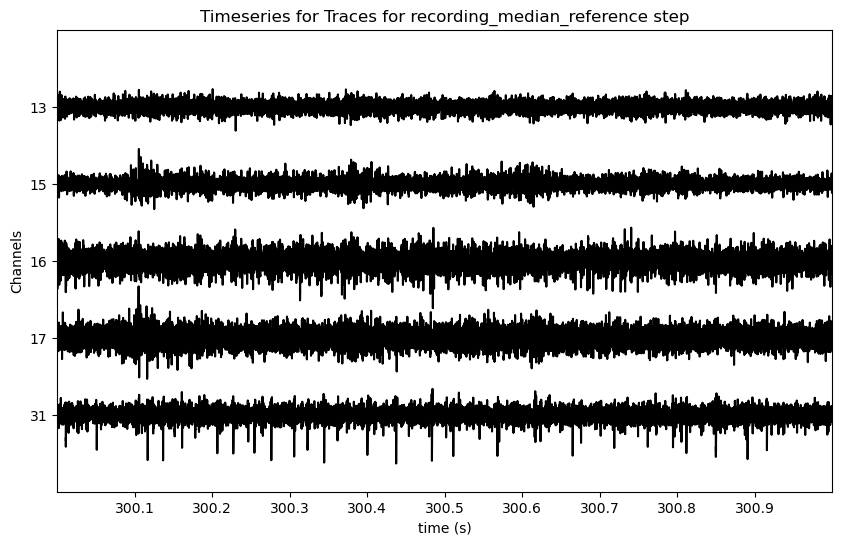

In [101]:
for key, value in preprocessing_step_dict.items():
    sw.plot_timeseries(value, time_range=time_range, channel_ids=channel_ids, show_channel_ids=True)
    plt.title("Timeseries for Traces for {} step".format(key))
    plt.ylabel("Channels")
    
    plt.legend().remove()
    plt.show()

# Part 4: Saving the Preprocessed files to folder

- Creating a directory within the recording directory for preprocessing and saving the preprocessed recordings into it 

In [102]:
preprocessing_output_directory = os.path.join(parent_output_directory, "preprocessing")


In [103]:
if not os.path.exists(preprocessing_output_directory):
    recording_intermediate.save_to_folder(name="preprocessing", folder=preprocessing_output_directory)
else:
    warnings.warn("""Directory already exists for: {}. 
    Either continue on if you are satisfied with the previous run 
    or delete the directory and run this cell again""".format(preprocessing_output_directory))

write_binary_recording with n_jobs = 1 and chunk_size = 20000


write_binary_recording: 100%|#| 1201/1201 [00:26<00:


# Chapter 3: Spike Sorting

In [104]:
all_preprocessed_directories = glob.glob("./proc/**/preprocessing", recursive=True)


In [105]:
recording_intermediate = spikeinterface.core.load_extractor(file_or_folder_or_dict=all_preprocessed_directories[0])

Now you are ready to spike sort using the :code:`sorters` module!
Let's first check which sorters are implemented and which are installed



In [106]:
print('Available sorters', ss.available_sorters())

Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'klusta', 'mountainsort4', 'pykilosort', 'spykingcircus', 'spykingcircus2', 'tridesclous', 'tridesclous2', 'waveclus', 'waveclus_snippets', 'yass']


The :code:`ss.installed_sorters()` will list the sorters installed in the machine.
We can see we have mountainsort4 and Tridesclous installed.
Spike sorters come with a set of parameters that users can change.
The available parameters are dictionaries and can be accessed with:



# NOTE: Change the name of the sorter if you want to use a different sorter

In [107]:
sorter_name = 'mountainsort4'

In [108]:
ss_params = ss.get_default_sorter_params(sorter_name)

In [109]:
print(ss_params)

{'detect_sign': -1, 'adjacency_radius': -1, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True, 'num_workers': 1, 'clip_size': 50, 'detect_threshold': 3, 'detect_interval': 10, 'tempdir': None}


Let's run a spike sorter and change one of the parameter, say, the detect_threshold:



- Changing the default parameters for these parameters

In [110]:
# To look for negative and positive peaks
ss_params['detect_sign'] = 0
# So that each channel is sorted all together
ss_params['adjacency_radius'] = 700
# False because we have already filtered the recordings
ss_params['filter'] = False
ss_params['num_workers'] = multiprocessing.cpu_count()

In [111]:
ss_params

{'detect_sign': 0,
 'adjacency_radius': 700,
 'freq_min': 300,
 'freq_max': 6000,
 'filter': False,
 'whiten': True,
 'num_workers': 16,
 'clip_size': 50,
 'detect_threshold': 3,
 'detect_interval': 10,
 'tempdir': None}

## Creating a folder for Spike Sorting Output

- Saving the parameters for the spike sorting

In [112]:
with open(os.path.join(parent_output_directory, "ss_params.pkl"), 'wb') as fp:
    pickle.dump(ss_params, fp)

- Sorting usually takes at least a hour. Uncomment the code block below to run it. 

In [113]:
all_sorter_methods = [sorter for sorter in dir(ss) if sorter_name in sorter and "run" in sorter]

In [114]:
all_sorter_methods

['run_mountainsort4']

In [115]:
sorter_method_name = all_sorter_methods[0]

In [116]:
sorter_method_call = getattr(ss, sorter_method_name)

In [117]:
sorter_method_call

<function spikeinterface.sorters.runsorter.run_mountainsort4(*args, **kwargs)>

In [118]:
child_spikesorting_output_directory = os.path.join(parent_output_directory,"ss_output")

In [119]:
child_spikesorting_output_directory

'./proc/20221219_124942_6_1_novel_merged/ss_output'

In [120]:
sorter_method_call(recording=recording_intermediate,
                              verbose=True,
                                output_folder=child_spikesorting_output_directory,
                                **ss_params)

whitening
Mountainsort4 use the OLD spikeextractors mapped with NewToOldRecording
Using temporary directory None
Using 16 workers.
Using tempdir: /tmp/tmp33xsshxk
Num. workers = 16
Preparing /tmp/tmp33xsshxk/timeseries.hdf5...
Preparing neighborhood sorters (M=32, N=24011275)...
Neighboorhood of channel 11 has 32 channels.
Detecting events on channel 12 (phase1)...
Neighboorhood of channel 21 has 32 channels.
Detecting events on channel 22 (phase1)...
Neighboorhood of channel 29 has 32 channels.
Detecting events on channel 30 (phase1)...
Neighboorhood of channel 3 has 32 channels.
Detecting events on channel 4 (phase1)...
Neighboorhood of channel 30 has 32 channels.
Detecting events on channel 31 (phase1)...
Neighboorhood of channel 27 has 32 channels.
Detecting events on channel 28 (phase1)...
Elapsed time for detect on neighborhood: 0:00:13.964872
Num events detected on channel 4 (phase1): 69278
Computing PCA features for channel 4 (phase1)...
Elapsed time for detect on neighborhood:

Elapsed time for detect on neighborhood: 0:00:11.525850
Num events detected on channel 32 (phase1): 87987
Computing PCA features for channel 32 (phase1)...
Elapsed time for detect on neighborhood: 0:00:11.723853
Num events detected on channel 26 (phase1): 73962
Computing PCA features for channel 26 (phase1)...
Elapsed time for detect on neighborhood: 0:00:12.620626
Num events detected on channel 10 (phase1): 74406
Computing PCA features for channel 10 (phase1)...
Elapsed time for detect on neighborhood: 0:00:13.729447
Num events detected on channel 9 (phase1): 87684
Computing PCA features for channel 9 (phase1)...
Clustering for channel 3 (phase1)...
Found 6 clusters for channel 3 (phase1)...
Computing templates for channel 3 (phase1)...
Clustering for channel 32 (phase1)...
Clustering for channel 10 (phase1)...
Clustering for channel 26 (phase1)...
Re-assigning events for channel 3 (phase1)...
Neighboorhood of channel 18 has 32 channels.
Detecting events on channel 19 (phase1)...
Foun

Found 5 clusters for channel 28 (phase2)...
Found 2 clusters for channel 23 (phase2)...
Neighboorhood of channel 8 has 32 channels.
Computing PCA features for channel 9 (phase2)...
No duplicate events found for channel 26 in phase2
Clustering for channel 27 (phase2)...
No duplicate events found for channel 31 in phase2
Clustering for channel 32 (phase2)...
Clustering for channel 15 (phase2)...
Found 5 clusters for channel 27 (phase2)...
Neighboorhood of channel 20 has 32 channels.
Computing PCA features for channel 21 (phase2)...
No duplicate events found for channel 20 in phase2
Clustering for channel 21 (phase2)...
Found 0 clusters for channel 21 (phase2)...
Neighboorhood of channel 17 has 32 channels.
Computing PCA features for channel 18 (phase2)...
No duplicate events found for channel 17 in phase2
Clustering for channel 18 (phase2)...
Found 0 clusters for channel 18 (phase2)...
Neighboorhood of channel 12 has 32 channels.
Computing PCA features for channel 13 (phase2)...
No dupli

NpzSortingExtractor: 85 units - 1 segments - 20.0kHz
  file_path: /nancy/projects/extracellular_ephys_analysis/notebooks/spike_sorting/proc/20221219_124942_6_1_novel_merged/ss_output/sorter_output/firings.npz

In [121]:
spike_sorted_object = ss.read_sorter_folder(child_spikesorting_output_directory)

In [130]:
spike_sorted_object

NpzSortingExtractor: 85 units - 1 segments - 20.0kHz
  file_path: /nancy/projects/extracellular_ephys_analysis/notebooks/spike_sorting/proc/20221219_124942_6_1_novel_merged/ss_output/sorter_output/firings.npz

- Plotting the Rasters

In [122]:
start_time, start_time + duration

(300, 24011575)

Text(0, 0.5, 'Unit IDs')

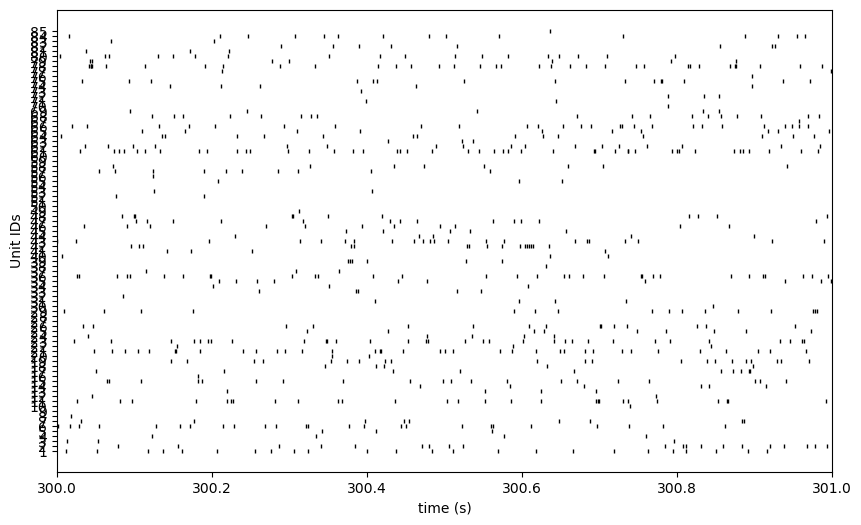

In [123]:
sw.plot_rasters(spike_sorted_object, time_range=time_range)
plt.ylabel("Unit IDs")

In [124]:
unit_ids = np.random.choice(spike_sorted_object.get_unit_ids(), size=5, replace=False)

In [125]:
unit_ids = sorted(unit_ids, key=lambda x: float(x))

Text(0, 0.5, 'Unit IDs')

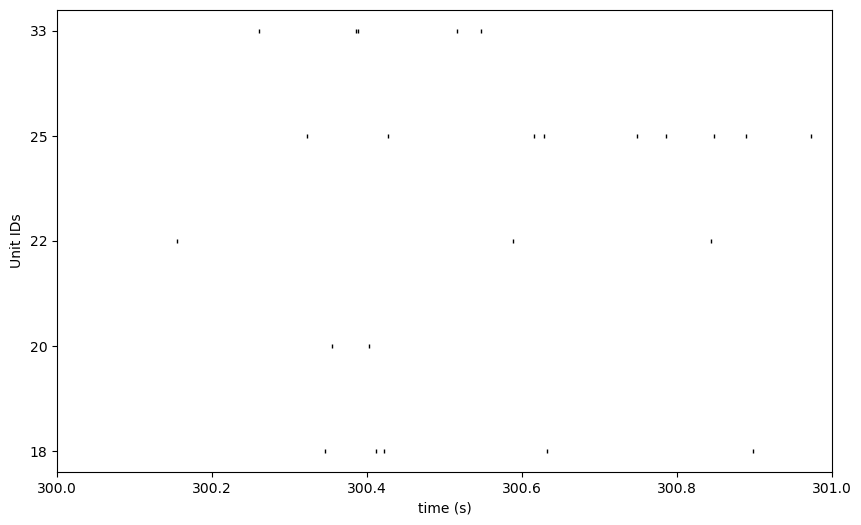

In [126]:
sw.plot_rasters(spike_sorted_object, time_range=time_range, unit_ids=unit_ids)
plt.ylabel("Unit IDs")

# Chapter 4: Post Processing

- Different resources to look at for Post Processing
    - https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_2_postprocessing.html
    - https://github.com/SpikeInterface/spiketutorials/blob/master/Official_Tutorial_SI_0.90_Aug2021/SpikeInterface_Tutorial.ipynb
    - https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_3_quality_mertics.html
    - https://catalystneuro.github.io/spike-sorting-hackathon/

## Creating a folder for Spike Sorting Output

- Creating a directory within the spike sorting directory for saving extracted waveforms 

In [127]:
waveform_output_directory = os.path.join(parent_output_directory, "waveforms")

In [128]:
waveform_output_directory

'./proc/20221219_124942_6_1_novel_merged/waveforms'

## Extracting Waveforms

- The WaveformExtractor class:
    - randomly samples a subset spikes with max_spikes_per_unit
    - extracts all waveforms snippets for each unit
    - saves waveforms in a local folder
    - can load stored waveforms
    - retrieves template (average or median waveform) for each unit
    - https://spikeinterface.readthedocs.io/en/latest/modules/core/plot_4_waveform_extractor.html



- Extracting waveforms from preprocessed recordings and spike sorted output from spike_sorted 
    - Based on Maya's settings in recorded video 
    - Saving to folder

In [129]:
we_spike_sorted = si.extract_waveforms(recording=recording_intermediate, 
                                       sorting=spike_sorted_object, folder=waveform_output_directory,
                                      ms_before=1, ms_after=1, progress_bar=True,
                                      n_jobs=8, total_memory="1G", overwrite=True,
                                       max_spikes_per_unit=2000)

extract waveforms memmap: 100%|█| 13/13 [00:04<00:00/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7d85b6820>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7b1d1eb20>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc72ce142e0>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7d85b6820>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib

- Loading from folder

In [131]:
we_spike_sorted = WaveformExtractor.load_from_folder(waveform_output_directory)

- Make into code cell if you want to look at details of waveform extraction

In [132]:
si.extract_waveforms??

# Exporting for Manual Curation

Once we have the  `WaveformExtractor` object
we can post-process, validate, and curate the results. With
the :code:`toolkit.postprocessing` submodule, one can, for example,
get waveforms, templates, maximum channels, PCA scores, or export the data
to Phy. `Phy <https://github.com/cortex-lab/phy>`_ is a GUI for manual
curation of the spike sorting output. To export to phy you can run:



In [133]:
si.WaveformExtractor??

In [134]:
phy_output_directory = os.path.join(parent_output_directory, "phy")

In [135]:
phy_output_directory

'./proc/20221219_124942_6_1_novel_merged/phy'

In [ ]:
export_to_phy??

In [136]:
export_to_phy(we_spike_sorted, phy_output_directory, compute_pc_features=True, compute_amplitudes=True, n_jobs=-1, verbose=True, mp_context="fork", total_memory="1G", chunk_size=5000)

write_binary_recording with n_jobs = 16 and chunk_size = 5000


write_binary_recording: 100%|█| 4803/4803 [00:00<00:/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7d85b6820>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7b1d1eb20>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc72ce142e0>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7d85b6820>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib

/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7d85b6820>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7b1d1eb20>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc72ce142e0>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7d85b6820>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: Resourc

/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7d85b6820>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7b1d1eb20>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc72ce142e0>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7d85b6820>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: Resourc

/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7d85b6820>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7b1d1eb20>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc72ce142e0>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7d85b6820>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: Resourc

/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7d85b6820>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7b1d1eb20>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc72ce142e0>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc7d85b6820>
  self.pid = os.fork()
/nancy/projects/extracellular_ephys_analysis/bin/pip_spike_interface_env/lib/python3.9/multiprocessing/popen_fork.py:66: Resourc

Run:
phy template-gui  /nancy/projects/extracellular_ephys_analysis/notebooks/spike_sorting/proc/20221219_124942_6_1_novel_merged/phy/params.py


## **Then you can run the template-gui with: `phy template-gui phy/params.py`
and manually curate the results.**



In [137]:
bool

bool

In [ ]:
raise ValueError("Following cells are for visualization and quality checking.")

## Signal to Noise Ratio of Each Unit

- Calculating Signal to Noise Ratio

In [ ]:
we_spike_sorted

In [ ]:
we_spike_sorted_signal_to_noise = st.compute_snrs(we_spike_sorted).values()

In [ ]:
we_spike_sorted_signal_to_noise

In [ ]:
len(we_spike_sorted_signal_to_noise)

- Filtering the Units that have higher signal to noise ratios
    - **NOTE**: If the histogram does not show enough information, either raise or lower the number of bins

In [ ]:
plt.hist(we_spike_sorted_signal_to_noise, bins=23)

- Creating a mask based on whether the SNR ratio is higher than what we specified
    - **NOTE**: Change the minimum signal to noise ratio based on the number of units that you want

In [ ]:
mask = np.array(list(we_spike_sorted_signal_to_noise)) > 12

In [ ]:
mask

In [ ]:
spike_sorted_object.get_unit_ids()

- We will get a list of all the Unit IDs that have higher SNR ratios based on the indexes of these units in the mask

In [ ]:
high_snr_units = spike_sorted_object.get_unit_ids()[mask]

In [ ]:
high_snr_units

In [ ]:
len(spike_sorted_object.get_unit_ids()[mask])

## Plotting the Waveforms for a single unit

- Each column represents a single channel
    - We are plotting the units with the highest signal to noise ratio
    - **NOTE**: Channels can be zero indexed, so the first channel will be numbered zero. Second will be one. And so on

In [ ]:
we_spike_sorted

- TODO: Change X ticks so that they correspond to channel ID's

In [ ]:
for unit_id in high_snr_units:
    w = sw.plot_unit_waveforms(we_spike_sorted, unit_ids=[unit_id], plot_templates=True, plot_channels=True)

In [ ]:
for unit_id in high_snr_units:
    w = sw.plot_unit_templates(we_spike_sorted, unit_ids=[unit_id])



In [ ]:
w = sw.plot_unit_probe_map(we_spike_sorted, unit_ids=[1])


## Plotting the Waveforms for a single channel

- Plotting the Average Waveforms (AKA Unit templates)

In [ ]:
for index, channel in enumerate(recording_preprocessed.get_channel_ids()):
    number_of_units_to_plot = len(high_snr_units)
    colors = iter(cm.rainbow(np.linspace(0, 1, number_of_units_to_plot)))

    fig, ax = plt.subplots()
    for i, unit_id in enumerate(high_snr_units[:number_of_units_to_plot]):
        template = we_spike_sorted.get_template(unit_id)
        color = next(colors)
        ax.plot(template[:, index].T, color=color, lw=3, label=unit_id)
    ax.legend()
    ax.set_title("Average waveforms for channel: {}".format(channel))
    plt.show()
    plt.close()

- Plotting the Unit Summary for the high snr units

In [ ]:
for index, unit_id in enumerate(high_snr_units):
    w = sw.plot_unit_summary(we_spike_sorted, unit_id=unit_id)
    plt.show()
    plt.close()

- Plotting the Unit Summary for the low snr units

In [ ]:
for index, unit_id in enumerate(spike_sorted_object.get_unit_ids()[~mask]):
    w = sw.plot_unit_summary(we_spike_sorted, unit_id=unit_id)
    plt.show()
    plt.close()

- Waveform and Template Shapes
    - For waveforms, the dimension is (num_spikes, num_samples, num_channels), while each template has dimension (num_samples, num_channels). 

In [ ]:
unit_id = high_snr_units[0]

waveforms = we_spike_sorted.get_waveforms(unit_id=unit_id)
print(f"Waveforms shape: {waveforms.shape}")
template = we_spike_sorted.get_template(unit_id=unit_id)
print(f"Template shape: {template.shape}")
all_templates = we_spike_sorted.get_all_templates()
print(f"All templates shape: {all_templates.shape}")



- The number of spikes for other waveforms
    - All are num waveforms are maxed out because we specied with the Waveform Extractor

In [ ]:
unit_to_waveform_and_spike_number = defaultdict(dict)
for unit in spike_sorted_object.get_unit_ids():
    waveforms = we_spike_sorted.get_waveforms(unit_id=unit)
    spiketrain = spike_sorted_object.get_unit_spike_train(unit)
#     print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")
    unit_to_waveform_and_spike_number[unit]["number_of_waveforms"] = waveforms.shape[0]
    unit_to_waveform_and_spike_number[unit]["number_of_spikes"] = len(spiketrain)


In [ ]:
unit_to_waveform_and_spike_number

# PCA Scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

### Getting the Principal Components

- Calculating Principal Components
    - We will first be using the local channel option

In [ ]:
pc = st.compute_principal_components(we_spike_sorted, load_if_exists=True,
                                     n_components=3, mode='by_channel_local')


In [ ]:
len(spike_sorted_object.get_unit_ids())

In [ ]:
spike_sorted_object.get_unit_ids()[0]

- For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). The get_all_components() function returns an array with the label/unit id for each component (all_labels) and an array of dimension (num_all_samples, num_components, num_channels).

In [ ]:
pc1 = pc.get_projections(unit_id=1)
print(f"PC scores shape: {pc1.shape}")
all_labels, all_pcs = pc.get_all_projections()
print(f"All PC scores shape: {all_pcs.shape}")



- Plotting the PCA for units with high SNR for each channel
    - **NOTE**: If you see distinct clusters in the PCA plots. Then you will likely see a distinct spike for that unit in the same channel in the average waveforms plots. 

In [ ]:
for channel_id in recording_preprocessed.get_channel_ids():
    fig, ax = plt.subplots()
    n = len(high_snr_units) + 1
    colors = iter(cm.rainbow(np.linspace(0, 1, n)))
    for i, unit_id in enumerate(high_snr_units):
        comp = pc.get_projections(unit_id)
        color = next(colors)
        ax.scatter(comp[:, 0, int(channel_id)], comp[:, 1, int(channel_id)], color=color, label=unit_id)
    ax.set_title("PCA for channel: {}".format(channel_id))
    plt.legend()
    plt.show()
    plt.close()

# Compute template metrics

- Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `toolkit` allows one to compute several of these metrics:

In [ ]:
template_metrics = st.calculate_template_metrics(we_spike_sorted, peak_sign="neg")

In [ ]:
template_metrics


# Validation and Curation with Quality Metrics

Quality metrics for the spike sorting output are very important to asses the spike sorting performance.
The :code:`spikeinterface.toolkit.qualitymetrics` module implements several quality metrics
to assess the goodness of sorted units. Among those, for example,
are signal-to-noise ratio, ISI violation ratio, isolation distance, and many more.
Theses metrics are built on top of WaveformExtractor class and return a dictionary with the unit ids as keys:



In [ ]:
isi_violations = st.compute_isi_violations(we_spike_sorted, isi_threshold_ms=1.5)

In [ ]:
print("ISI Violation Rate: {}".format(isi_violations[0]))


In [ ]:
plt.hist(isi_violations[1])

All theses quality metrics can be computed in one shot and returned as
a :code:`pandas.Dataframe`



In [ ]:
metrics = st.compute_quality_metrics(we_spike_sorted)

- Each row is a Unit

In [ ]:
metrics

Quality metrics can be also used to automatically curate the spike sorting
output. For example, you can select sorted units with a SNR above a
certain threshold:



In [ ]:
snr_thresh = 5
isi_viol_thresh = 0.2

In [ ]:
our_query = f"snr > {snr_thresh} & isi_violations_rate < {isi_viol_thresh}"
print(our_query)

In [ ]:
keep_units = metrics.query(our_query)
keep_unit_ids = keep_units.index.values

In [ ]:
sorting_auto = spike_sorted_object.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(spike_sorted_object.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto.get_unit_ids())}")

# Plotting Channels with Multiple Units

## Compute unit maximum channel¶

- For each unit, calculating the channel with the highest the most extreme signal

In [ ]:
extremum_channels_ids = st.get_template_extremum_channel(we_spike_sorted, peak_sign='neg')
print(extremum_channels_ids)

In [ ]:
extremum_channels_ids = st.get_template_extremum_channel(we_spike_sorted, peak_sign='pos')
print(extremum_channels_ids)

- Getting the channel that's the top channel for multiple units

In [ ]:
channel_to_units = defaultdict(dict)
for k, v in extremum_channels_ids.items():
    channel_to_units[v] = channel_to_units.get(v, []) + [k]

In [ ]:
channel_to_units

In [ ]:
channel_to_multiple_units = {k:v for k, v in channel_to_units.items() if len(v) >=2}

In [ ]:
channel_to_multiple_units

- PCA Plots

In [ ]:
for channel, multiple_units in channel_to_multiple_units.items():

    n = len(multiple_units) + 1
    colors = iter(cm.rainbow(np.linspace(0, 1, n)))

    fig, ax = plt.subplots()
    for i, unit_id in enumerate(multiple_units):
        comp = pc.get_projections(unit_id)
#         print(comp.shape)
        color = next(colors)
        ax.scatter(comp[:, 0, int(channel)], comp[:, 1, int(channel)], color=color, label=unit_id)
    ax.legend()
#     print(channel)
    ax.set_title("PCA Plot for Channel: {}".format(str(channel)))
    plt.show()
    plt.close()

# Looking over the waveforms for the different unit groups

In [ ]:
for channel, multiple_units in channel_to_multiple_units.items():
    print("Channel: {}".format(channel))
    for unit in multiple_units:
        print("Unit: {}".format(unit))
        sw.plot_unit_templates(we_spike_sorted, channel_ids=recording_preprocessed.channel_ids, unit_ids=[unit], plot_templates=True, plot_channels=True)
        plt.show()
        plt.close()

In [ ]:
for channel, multiple_units in channel_to_multiple_units.items():
    print("Channel: {}".format(channel))
    for unit in multiple_units:
        print("Unit: {}".format(unit))
        w = sw.plot_unit_summary(we_spike_sorted, unit_id=unit)
        plt.show()
        plt.close()

# Supplementary Visualization and Quality Metrics

In [ ]:
raise ValueError("Cells below are other options for visualizations and quality metrics. They take time and are still being tested, so running the rest of the notebook is not necessary. They are for those that want to look further into the recording data and the the postprocessing steps.")

## Spike Amplitudes

- Spike amplitudes can be computed with the `get_spike_amplitudes` function.


In [ ]:
amplitudes = st.get_spike_amplitudes(we_spike_sorted, outputs="concatenated", progress_bar=True)

In [ ]:
amplitudes[0].shape

In [ ]:
sw.plot_amplitudes_distribution(we_spike_sorted, unit_ids=high_snr_units)

In [ ]:
sw.plot_amplitudes_timeseries(we_spike_sorted, unit_ids=high_snr_units[:1])

By default, all amplitudes are concatenated in one array.

The correspinding spike times and labels can be easily retrieved as:

In [ ]:
all_spike_times, all_spike_labels = spike_sorted_object.get_all_spike_trains()[0]


- The [0] index is to select the first segment. In case of multiple segments each element will correspond to a different segment and will contain spike times and labels for that segment.


## ISI Violations

- https://github.com/SpikeInterface/spikeinterface/blob/master/spikeinterface/toolkit/qualitymetrics/misc_metrics.py
- https://numpy.org/doc/stable/reference/generated/numpy.diff.html

- The code that's used for the ISI Calcuations which suggest that only the differences between neighbors are being calculated

In [ ]:

# all units converted to seconds
for unit_id in unit_ids:
    num_violations = 0
    num_spikes = 0
    for segment_index in range(num_segs):
        spike_train = sorting.get_unit_spike_train(unit_id=unit_id, segment_index=segment_index)
        isis = np.diff(spike_train)
        num_spikes += len(spike_train)
        num_violations += np.sum(isis < isi_threshold_samples)
    violation_time = 2 * num_spikes * (isi_threshold_s - min_isi_s)

- TODO: Install pyarrow

In [ ]:
spike_sorted_quality_metrics_df

## Filtering based on metrics

- Focusing on:
    - snr, isi_violations_rate, isolation_distance

In [ ]:
good_units = spike_sorted_quality_metrics_df[(spike_sorted_quality_metrics_df["snr"] >= 4) & (spike_sorted_quality_metrics_df["isi_violations_rate"] < 0.01)]

In [ ]:
adequate_units = spike_sorted_quality_metrics_df[(spike_sorted_quality_metrics_df["snr"] >= 4) & (spike_sorted_quality_metrics_df["isi_violations_rate"] < 0.05) & (spike_sorted_quality_metrics_df["isi_violations_rate"] > 0.01)]

In [ ]:
good_units

In [ ]:
adequate_units

- Looking over the unit summaries of units that match our criteria

In [ ]:
for index, unit in good_units.iterrows():
    w = sw.plot_unit_summary(we_spike_sorted, unit_id=index)

## 3D Plots for PCA

In [ ]:
from mpl_toolkits import mplot3d

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax = plt.axes(projection='3d')

In [ ]:
for channel, multiple_units in channel_to_multiple_units.items():

    n = len(multiple_units) + 1
    colors = iter(cm.rainbow(np.linspace(0, 1, n)))

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for i, unit_id in enumerate(multiple_units):
        comp = pc.get_components(unit_id)
#         print(comp.shape)
        color = next(colors)
#         ax.scatter(comp[:, 0, 8], comp[:, 1, 8], color=color, label=unit_id)
        ax.scatter3D(comp[:, 0, int(channel)], comp[:, 1, int(channel)], comp[:, 2, int(channel)], c=color, cmap='Greens', label=unit_id);
        
    # make simple, bare axis lines through space:
    xAxisLine = ((min(comp[:, 0, int(channel)]), max(comp[:, 0, int(channel)])), (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
    yAxisLine = ((0, 0), (min(comp[:, 1, int(channel)]), max(comp[:, 1, int(channel)])), (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
    zAxisLine = ((0, 0), (0,0), (min(comp[:, 2, int(channel)]), max(comp[:, 2, int(channel)])))
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    
    ax.legend()
#     print(channel)
    ax.set_title("PCA Plot for Channel: {}".format(str(channel)))
    plt.show()
    plt.close()